# Stepped Sine Injection 解析 (Response Function Analysis) チュートリアル

このノートブックでは `gwexpy` の `response` モジュールを使用して、Stepped Sine（離散周波数）インジェクション試験の解析を行う方法を示します。

## 目的
Stepped Sine 解析では、特定の周波数の正弦波を順番に注入し、各ステップでの応答を定常状態の加算平均 ASD を用いて評価することで、結合係数（Coupling Factor, CF）の周波数依存性（伝達関数）を精密に推定します。

ブロードバンド（広帯域）なランダムノイズ注入に比べ、特定の周波数において非常に高い SNR を確保できるため、微小な結合の測定や非線形性の検証に適しています。

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from astropy import units as u
from gwpy.timeseries import TimeSeries
from gwexpy.analysis.response import estimate_response_function, detect_step_segments

# グラフのスタイル設定
plt.rcParams["figure.figsize"] = (10, 6)

## 1. 擬似データの生成

複数の周波数ステップを持つ正弦波インジェクションデータをシミュレーションします。

- 注入周波数: [10, 25, 50, 100, 200, 500] Hz
- 各ステップの持続時間: 12秒
- バックグラウンド: ホワイトノイズ
- 結合係数: 周波数に依存する伝達関数を想定

In [2]:
fs = 2048  # サンプリング周波数 [Hz]
inj_freqs = [10, 25, 50, 100, 200, 500]
step_duration = 12.0  # 各ステップ 12秒
gap_duration = 6.0    # ステップ間の隙間 6秒 (4s FFT を確保するため)
total_duration = (step_duration + gap_duration) * len(inj_freqs) + gap_duration

t = np.linspace(0, total_duration, int(total_duration * fs), endpoint=False)

# 1. Witness Data (Stepped Sine)
wit_values = np.random.normal(0, 0.1, len(t))  # 基礎ノイズ
for i, freq in enumerate(inj_freqs):
    t_start = gap_duration + i * (step_duration + gap_duration)
    t_end = t_start + step_duration
    mask = (t >= t_start) & (t < t_end)
    # 正弦波を重畳 (振幅 1.0)
    wit_values[mask] += np.sin(2 * np.pi * freq * t[mask])

witness = TimeSeries(wit_values, sample_rate=fs, t0=0, unit=u.V, name="PEM:INJECTION_ACC")

# 2. Target Data (Response)
# 周波数 f に依存する結合係数を定義: CF(f) = 1e-23 * (f / 100)**-1
target_values = np.random.normal(0, 1e-24, len(t))  # 強めのバックグラウンドノイズ
for i, freq in enumerate(inj_freqs):
    t_start = gap_duration + i * (step_duration + gap_duration)
    t_end = t_start + step_duration
    mask = (t >= t_start) & (t < t_end)

    cf_true = 1e-23 * (freq / 100.0)**-1
    target_values[mask] += cf_true * np.sin(2 * np.pi * freq * t[mask])

target = TimeSeries(target_values, sample_rate=fs, t0=0, unit=u.m, name="GW:STRAIN")

print("Data generated successfully.")

Data generated successfully.


## 2. セグメントの自動検出

`detect_step_segments` を使用して、Witness 信号からインジェクションが行われている時間帯とその周波数を自動的に抽出します。

In [3]:
segments = detect_step_segments(witness, snr_threshold=20.0, min_duration=5.0)

print(f"Detected {len(segments)} segments:")
for i, (t_start, t_end, freq) in enumerate(segments):
    print(f"  Step {i}: t=[{t_start:6.1f}, {t_end:6.1f}] s, Freq={freq:6.1f} Hz")

Detected 6 segments:
  Step 0: t=[   7.0,   16.0] s, Freq=  10.0 Hz
  Step 1: t=[  25.0,   34.0] s, Freq=  25.0 Hz
  Step 2: t=[  43.0,   52.0] s, Freq=  50.0 Hz
  Step 3: t=[  61.0,   70.0] s, Freq= 100.0 Hz
  Step 4: t=[  79.0,   88.0] s, Freq= 200.0 Hz
  Step 5: t=[  97.0,  106.0] s, Freq= 500.0 Hz


## 3. レスポンス関数の推定

`estimate_response_function` を使用して解析を実行します。
各セグメントにおける Witness と Target の ASD を計算し、バックグラウンド補正を行った上で結合係数を算出します。

In [4]:
# 解析の実行
# auto_detect=True (デフォルト) の場合は内部で自動検出が行われますが、
# ここでは上で検出したセグメントを明示的に渡します。
result = estimate_response_function(
    witness=witness,
    target=target,
    segments=segments,
    fftlength=4.0,
    overlap=2.0
)

print("Analysis complete.")

Analysis complete.


## 4. 結果の可視化

推定されたレスポンス関数をいくつかの方法で可視化します。

### 4.1 結合係数の周波数依存性 (Transfer Function)

`plot()` メソッドは、注入周波数ごとの結合係数をプロットします。

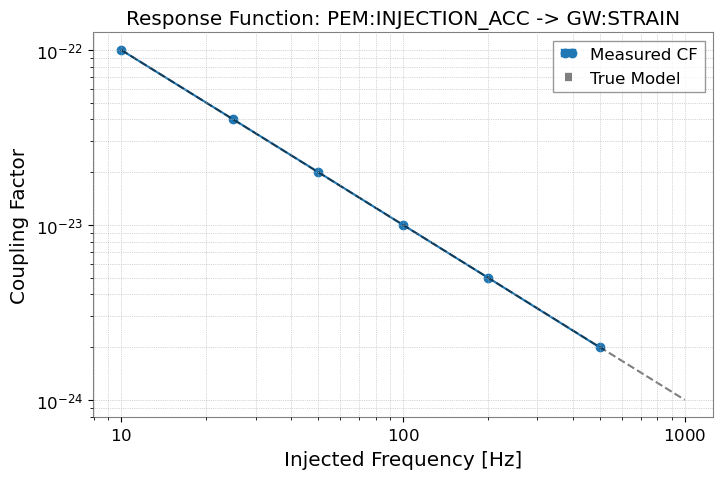

In [5]:
ax = result.plot()

# 真値 (1e-23 * (f/100)**-1) を重ねて描画
f_fine = np.logspace(1, 3, 100)
cf_true_fine = 1e-23 * (f_fine / 100.0)**-1
ax.loglog(f_fine, cf_true_fine, 'k--', alpha=0.5, label="True Model")
ax.legend()

### 4.2 各ステップの詳細解析 (Snapshot)

`plot_snapshot()` を使用すると、特定のステップにおける Target の ASD とバックグラウンドの関係を確認できます。

<AxesSubplot: title={'center': 'Step Snapshot @ 100.0 Hz (t0=61.0)'}, xlabel='Frequency [Hz]', ylabel='ASD [m]'>

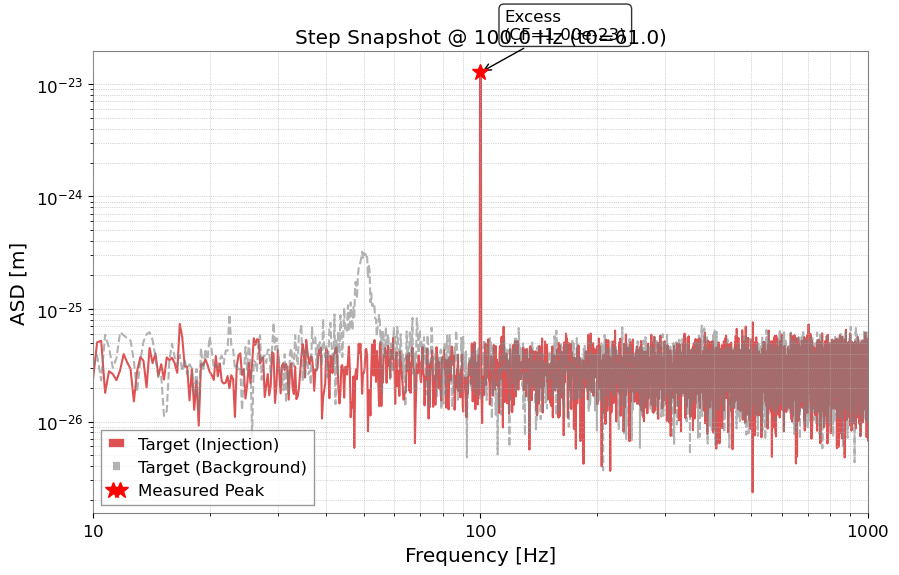

In [6]:
# 100 Hz ステップの結果を確認
result.plot_snapshot(freq=100)

### 4.3 レスポンスマップ (2D Map)

`plot_map()` は、横軸を注入周波数、縦軸を応答周波数とした2次元マップを表示します。
これにより、注入した周波数以外の帯域に応答が出ていないか（高調波結合などの非線形性がないか）を一目で確認できます。

<AxesSubplot: title={'center': 'Response Matrix'}, xlabel='Injected Frequency [Hz]', ylabel='Response Frequency [Hz]'>

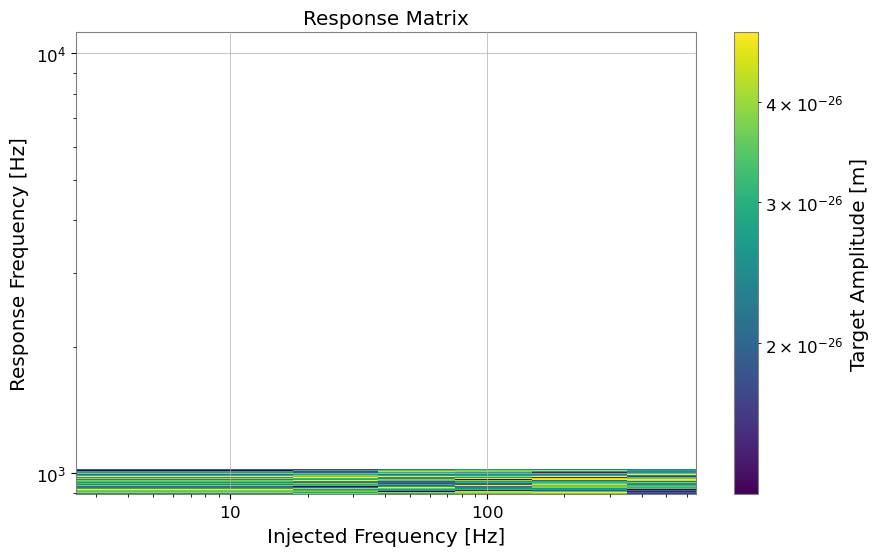

In [7]:
result.plot_map()